# Multiclass logistic regression

아래 예제는 손으로 쓴 숫자를 Image classfication을 통해 구분하는 예제입니다.
![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png) 
Multiclass logistic regression (또는 softmax regression, multinomial regression) 을 통해 숫자를 구분하는 모델을 실습하겠습니다. 필요한 Library를 Import 합니다.

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

아래는 모델링 연산을 CPU만을 사용할지, GPU를 활용(mx.gpu(0))할지 선택하는 옵션입니다. 

In [2]:
ctx = mx.cpu()

## The MNIST dataset

잘 알려진 Dataset인 MNIST dataset은 28x28 의 흑백으로 손으로 그려진 숫자 이미지를 제공합니다. 0에서 9의 숫자들을로 이루어져 있습니다. 우선은 MXNet 기능을 활용하여 Dataset을 가져옵니다. 가져온 이미지를 float [0,1]로 변환합니다. 

MNIST dataset detail: http://yann.lecun.com/exdb/mnist/

In [3]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

Dataset은 Training 용도와 Testing 용도로 구분합니다. 각 데이터 하나는 image와 label를 가집니다

In [4]:
image, label = mnist_train[0]
print(image.shape, label)

(28L, 28L, 1L) 5.0


추가로 이 이미지 하나는 (channel, height, width)의 세가지 속성을 가지고, 만약 컬러 이미지라면 channel은 (red, green, and blue) 의 dimension을 가집니다.

## Record the data and label shapes

input 값과 output 값의 개수를 정의합니다. 


In [5]:
num_inputs = 784
num_outputs = 10

Machine Learning 라이브러리는 일반적으로 (batch, channel, height, width)정보를 이미지에서 찾습니다. 그러나, 대부분 시작화를 하기 위한 라이브러리는 (height, width, channel)을 선호합니다. 아래에서 속성을 변환합니다.

In [6]:
im = mx.nd.tile(image, (1,1,3))
print(im.shape)

(28L, 28L, 3L)


변경하고나면 image를 시각화하여 볼 수 있습니다. 

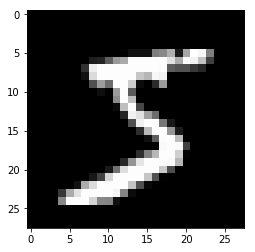

In [7]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

숫자 5를 볼 수 있습니다.

## Load the data iterator

이제 이미지 데이터들을 iterator에 읽어드립니다.

In [8]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

Test를 위한 이미지 데이터 역시 읽어드립니다. 후에 생성된 모델에 테스트 데이터를 이용하여 검증합니다.

In [9]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

## Allocate model parameters

이제 모델을 정의합니다. 이번 랩에서는 Multimodal 구조를 사용하지는 않으며, 단순히 각각의 이미지를 single ID vector로 만듭니다. 28x28 = 784 의 경우의 수가 나옵니다. 

Multiclass classfication 모델을 이용하므로, 입력된 이미지에 대해서 probability 를 추가합니다. 그렇게 하기 위해서는 각 클래스마다 784 wegihts를 가지는 별도의 vector가 하나 필요합니다. 10개의 class가 있으므로, 784 by 10 matrix를 가지게 됩니다.

그리고, 각각의 결과마다 하나의 offset을 추가합니다. 이것을 *bias term*으로 정의합니다. 그리고 그것을 10-dimensional array ``b``에 저장합니다.

In [10]:
W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]

MXNet이 트레이닝 중에 각 파라미터에 대해서 gradients 를 가지도록 설정합니다.

In [11]:
for param in params:
    param.attach_grad()

## Multiclass logistic regression

앞서 진행한 Linear regression 랩에서 결과값으로 *yhat*을 정의했었습니다. 그리고 최대한 실제 *y*값에 가깝도록 학습을 하였습니다. 이번에는 *classification*을 목적으로하여, 입력값인 *X*가 특정 *L* 클래스에 할당되는 것을 수행합니다.

설명한 것과 같이 기본적인 생각은 입력값 *X*을 10개의 다른 값으로 구분하여 결과값 ``y_linear``에 저장합니다. 그리고 이 결과값을 normalize합니다. 이 normalization 은 결과값이 양수로 처리되며 결과값 yhat으로 맞는 probability로 인식할 수 있게 합니다.

In [12]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear))
    partition =nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

In [13]:
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[ 0.01466005  0.03104205  0.09487285  0.11615293  0.07316667  0.01516553
   0.44094777  0.08199082  0.0917872   0.04021411]
 [ 0.0309542   0.07588483  0.37230074  0.03313261  0.0499984   0.13276106
   0.14566724  0.02354518  0.08515968  0.05059606]]
<NDArray 2x10 @cpu(0)>


모든 결과값의 합이 1인지 확인

In [14]:
print(nd.sum(sample_yhat, axis=1))


[ 1.  1.]
<NDArray 2 @cpu(0)>


약간의 차이는 있으나, 정상적으로 동작을 확인합니다.

## Define the model

이제 모델을 정의합니다.

In [15]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

## The  cross-entropy loss function

트레이닝을 시작하기전에, Loss function을 정의합니다. 여기서는 cross-entropy loss function 을 정의하여 사용합니다. Deep Learning에서 가장 많이 사용되는 Loss function 중 하나입니다. 일반적인 regression 보다 classification이 보다 많이 사용되기 때문입니다. 

기본적인 접근은 타겟 값인 Y는 10개 중 하나가 1인 vector값을 가집니다. 예를 들어 ``[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]``와 같은 값을 가집니다. 만약 이를 Label 2라 한다면, cross-entropy loss는 Y값이 Label 2에 속하는 값에 대해서만 Probability를 계산합니다.

In [16]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

## Optimizer

Linear regression에서 사용한 SGD(Stochastic gradient descent)를 사용합니다.

In [17]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Write evaluation loop to calculate accuracy

cross-entropy가 유용하긴 하지만 보통 사람들은 정확도를 생각할 때 전체 질문에 몇 개를 맞췄는지에 대해서 Performance를 생각합니다. 따라서 Accuracy를 생각할 떄 아래는 evaluation loop에서 각 Iterator, network, 전체 Dataset에 대해서 계산된 평균 accuracy를 고려합니다. 

In [18]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

당연하겠지만, 어떤 입력값이든 10개의 클래스 중에 하나에 포함되게 되므로, 기본적으로 0.10 의 accurary는 가져야합니다.

In [ ]:
evaluate_accuracy(test_data, net)

## Execute training loop

In [ ]:
epochs = 10
moving_loss = 0.
learning_rate = .001
smoothing_constant = .01

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
            
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))       

## Conclusion

약 90% 정확도를 확인할 수 있습니다. 